# Distinguer des chats et des chiens avec un classifieur linéaire

Dans ce notebook, nous allons entraîner un classifieur linéaire pour analyser des images de chats et de chiens. 

Les images que nous allons utiliser sont issues d'une [compétition de la plateforme Kaggle](https://www.kaggle.com/c/dogs-vs-cats/overview). Cette compétition, datant de 2013, a été remportée par un français, Pierre Sermanet (qui travaille maintenant pour Google Brain), qui a obtenu une précision de 98.9% en utilisant un réseau de neurones convolutionnel.

La précision attendue avec un classifieur linéaire est beaucoup plus faible.

Voici la structure de ce notebook : 
* [Imports](#imports)
* [Processus d'entraînement d'un algorithme d'apprentissage automatique](#processus)
* [Création d'un ensemble de données d'entraînement](#training)
    * [Téléchargement de l'ensemble des données](#telechargement)
    * [Sélection des images d'entraînement et de validation](#selection)
    * [Pré-traitement des images](#pretraitement)
* [Création d'un classifieur linéaire](#classifieur)
    * [Création et initialisation de la matrice de pondération](#matrice_ponderation)
    * [Définition d'une fonction coût](#fonction_cout)
    * [Définition de la descente de gradient](#descente_gradient)
* [Entraînement du classifieur](#entrainement)
* [Evaluation du classifieur](#evaluation)
* [Conclusion](#conclusion)
* [A vous de jouer](#avousdejouer)

## Imports et configuration <a class="anchor" id="imports"></a>

La commande ```%matplotlib inline``` permet d'afficher les graphiques de matplotlib avec la bibliothèque graphique intégrée à Notebook. Sans cette commande, les graphiques générés avec ```matplotlib```ne s'afficheront pas. 

In [1]:
%matplotlib inline

Importons maintenant les paquets nécessaires pour ce notebook. 

Les bibliothèques suivantes sont importées :
- La bibliothèque ```OpenCV```, qui s'importe avec la commande ```import cv2```, nous servira à lire et à prétraiter les images avant qu'elles n'entrent dans le classifieur ;
- ```Matplotlib``` est utilisée pour afficher des images et tracer des courbes ;
- ```Numpy``` sert à faire des calculs matriciels.  Les images lues par ```OpenCV``` sont stockées comme des matrices ```Numpy``` ;
- ```Os``` permet d'utiliser des fonctionnalités dépendantes du système d'exploitation, comme créer des dossiers, ou spécifier des chemins à partir de noms de dossiers ;
- ```Random``` permet de générer des nombres aléatoires. Nous nous en servirons pour initialiser les paramètres du classifieur ;
- ```Shutil``` contient divers outils de gestion des fichiers. Nous nous en servirons pour copier certaines images de la base de données ;
- La bibliothèque ```Scikit-Learn```, qui s'importe avec la commande ```import sklearn```, contient une grande quantité d'outils pour l'apprentissage automatique. Cette librairie nécessite d'importer individuellement tous les sous-paquets qui seront utilisés. Dans ce notebook, nous l'utiliserons pour calculer diverses métriques permettant d'évaluer la performance de notre classifieur, nous importons donc son sous-paquet ```metrics```.

In [2]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
import random
from shutil import copyfile
import sklearn.metrics

Ce notebook a été créé avec les versions de paquets suivantes :

In [3]:
print("Version d'OpenCV", cv2.__version__)
print("Version de Numpy", np.__version__)
print("Version de Scikit-Learn", sklearn.__version__)

Version d'OpenCV 4.8.0
Version de Numpy 1.23.4
Version de Scikit-Learn 1.1.2


Certains de ces paquets sont installés par défaut à l'installation de Python. D'autres doivent être installés séparément. 

Si l'import d'un de ces paquets échoue en renvoyant un message d'erreur spécifiant ```ModuleNotFoundError```, c'est probablement que le paquet n'a pas été installé. Dans ce cas, installez le paquet manquant en exécutant la commande ```!pip install <paquet manquant>```.

La cellule qui suit installe tous les paquets nécessaires à ce notebook. Commentez les lignes correspondant aux paquets qui sont déjà installés, exécutez la cellule pour installer les paquets restants, et exécutez à nouveau la cellule effectuant l'import des modules nécessaires. 

In [4]:
!pip install opencv-python
!pip install matplotlib
!pip install numpy
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'C:\Program Files\Python39\python.exe -m pip install --upgrade pip' command.


Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'C:\Program Files\Python39\python.exe -m pip install --upgrade pip' command.


Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'C:\Program Files\Python39\python.exe -m pip install --upgrade pip' command.


Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'C:\Program Files\Python39\python.exe -m pip install --upgrade pip' command.


Enfin, nous initialisons explicitement le générateur de nombres aléatoires de la bibliothèque ```Numpy```. De cette manière, si nous relançons un calcul utilisant un nombre aléatoire, c'est toujours le même nombre qui sera généré, ce qui permet de rendre le code de ce notebook reproductible.

In [5]:
np.random.seed(0)

## Processus d'entraînement d'un algorithme d'apprentissage automatique <a class="anchor" id="processus"></a>
Le processus que nous allons suivre ici est le même que pour entraîner n'importe quel algorithme d'apprentissage automatique de manière supervisée. 

Les étapes sont les suivantes :
- Nous commençons par **créer un ensemble de données d'entraînement**. C'est un ensemble d'images, dont on connaît les vraies étiquettes. 
- Ces données d'entraînement sont utilisées pour **entraîner un modèle**. Ce modèle prend une image en entrée, et donne une classe en sortie. Ce modèle possède un certain nombre de paramètres que l'on va chercher à optimiser pour améliorer sa performance. Pour cela, nous avons besoin de spécifier trois choses : outre la forme spécifique du **modèle**, nous devons aussi choisir la **fonction-coût**, qui définit ce qu'est une bonne performance pour notre modèle, et un **algorithme d'optimisation**, qui spécifie la manière dont les paramètres du modèle seront ajustés à chaque itération pour minimiser la fonction-coût. 
- Enfin, une fois que notre modèle est entraîné, nous réalisons une **évaluation de ses performances**. 

Remarquons que, dans ce notebook, nous nous contentons de définir un modèle, de l'entraîner et de l'évaluer. Il nous suffit donc de définir deux ensembles de données : un ensemble d'entraînement, et un ensemble de test. Si nous voulions améliorer progressivement notre modèle en lui apportant des améliorations successives et en comparant les performances de chacune des versions, alors nous aurions eu besoin de trois ensembles de données : un ensemble d'entraînement, pour entraîner les modèles, un ensemble de validation, pour choisir un des modèles, et un ensemble de test, pour estimer les performances du modèle choisi sur des nouvelles données. 

Ce notebook réalise chacune de ces étapes une à une. 

## Création d'un ensemble de données d'entraînement <a class="anchor" id="training"></a>

Il existe plusieurs manières d'obtenir cet ensemble de données :
- il peut être téléchargé depuis la [plateforme du concours, Kaggle](https://www.kaggle.com/c/dogs-vs-cats/overview). Ceci nécessite de s'inscrire et de créer un compte sur la plateforme ;
- il peut être téléchargé en utilisant la fonction ```load``` du [paquet ```tfds``` de tensorflow](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs?hl=en). Les données sont téléchargées au format TFRecord, un format binaire qui permet de stocker des images de manière beaucoup plus compacte et rapidement utilisable que les formats d'images classiques (png, jpeg, etc.), mais qui a l'inconvénient de ne pas permettre une visualisation immédiate du contenu ;
- il peut également être téléchargé depuis le site de [Microsoft](https://www.microsoft.com/en-us/download/details.aspx?id=54765). 

C'est cette dernière solution qui sera utilisée ici. 

Nous allons commencer par télécharger l'ensemble des données, mais nous n'en utiliserons qu'une fraction pour l'entraînement et les tests, afin de limiter les ressources (mémoire et calculs) requises. 

Une fois les données pour l'entraînement et les tests sélectionnées, nous aurons besoin de leur appliquer plusieurs prétraitements avant de les utiliser : nous allons les convertir en niveaux de gris, uniformiser leurs tailles, et normaliser leurs intensités pour qu'elles soient comprises entre 0 et 1. Enfin, nous les aplatirons, pour qu'elles soient sous le format d'un vecteur unidimensionnel. 

### Téléchargement de l'ensemble des données <a class="anchor" id="telechargement"></a>
Nous allons commencer par télécharger l'ensemble des données dans l'archive cats-and-dogs.zip. Nous allons ensuite décompresser l'archive dans le dossier tmp/PetImages, contenant les sous-dossiers 'Cat' et 'Dog'.

Si le lien de téléchargement ne fonctionne pas, vous pouvez exécuter toutes ces étapes manuellement, en commençant par télécharger les images depuis l'adresse https://www.microsoft.com/en-us/download/confirmation.aspx?id=54765.

Pour pouvoir télécharger les données, nous avons besoin d'installer le paquet ```wget```, qui permet de télécharger des fichiers depuis internet. 

Le paquet ```zipfile38``` nous servira à décompresser l'archive.

In [6]:
!pip install wget
!pip install zipfile38

Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'C:\Program Files\Python39\python.exe -m pip install --upgrade pip' command.


Defaulting to user installation because normal site-packages is not writeable


You should consider upgrading via the 'C:\Program Files\Python39\python.exe -m pip install --upgrade pip' command.


Nous pouvons maintenant télécharger les images dans l'archive ```cats-and-dogs.zip``` avec ```wget```.

In [7]:
import wget

url = "https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip"
local_zip_path = "cats-and-dogs.zip"
wget.download(url, local_zip_path)

100% [......................................................................] 824887076 / 824887076

'cats-and-dogs (1).zip'

Ensuite, nous décompressons l'archive grâce au paquet ```zipfile```.

In [8]:
import zipfile

local_zip_path = "cats-and-dogs.zip"
zip_ref = zipfile.ZipFile(local_zip_path, 'r')
zip_ref.extractall()
zip_ref.close()

Le dossier décompressé s'appelle ```PetImages```. 

Si vous l'ouvrez, vous découvrirez qu'il comporte deux sous-dossiers : ```Cat```, qui contient 12 501 images de chats, et ```Dog```, qui contient 12 501 images de chiens. 

### Sélection des images d'entraînement et de validation <a class="anchor" id="selection"></a>

Nous allons extraire une partie de ces images pour créer nos dossiers d'entraînement et de test. Nous utiliserons 200 images de chaque classe pour l'entraînement, et 20 pour les tests. 

Nous allons tout d'abord créer les répertoires nécessaires. L'arborescence sera la suivante :
```
cats-vs-dogs
└───train
│   └───cats
│   |   │   0.jpg
│   |   │   1.jpg
│   |   │   ...
│   └───dogs
│   |   │   0.jpg
│   |   │   1.jpg
│   |   │   ...   
└───test
│   └───cats
│   |   │   200.jpg
│   |   │   201.jpg
│   |   │   ...
│   └───dogs
│   |   │   200.jpg
│   |   │   201.jpg
│   |   │   ...   
```

Pour créer tous ces répertoires, nous allons utiliser la commande ```mkdir```, et l'appliquer dans une boucle sur tous les répertoires à créer. 

In [9]:
# Définition des noms de dossiers
root_dir = 'cats-vs-dogs'
train_dir = 'train'
test_dir = 'test'
cat_dir = 'Cat'
dog_dir = 'Dog'

# Création d'une liste contenant tous les chemins vers les dossiers à créer
directories_to_create = [
    root_dir,
    os.path.join(root_dir, train_dir),
    os.path.join(root_dir, train_dir, cat_dir),
    os.path.join(root_dir, train_dir, dog_dir),
    os.path.join(root_dir, test_dir),
    os.path.join(root_dir, test_dir, cat_dir),
    os.path.join(root_dir, test_dir, dog_dir)
]

# Création de chacun des dossiers
for directory in directories_to_create:
    try:
        os.mkdir(directory)
        print(directory, 'created')
    except:
        print(directory, 'failed')

cats-vs-dogs created
cats-vs-dogs\train created
cats-vs-dogs\train\Cat created
cats-vs-dogs\train\Dog created
cats-vs-dogs\test created
cats-vs-dogs\test\Cat created
cats-vs-dogs\test\Dog created


Nous allons maintenant copier une portion des images de la base de données originale vers ces nouveaux dossiers. 

In [10]:
# Définition du nombre d'images à copier dans chaque sous-dossier
nb_images_train_per_pet = 200
nb_images_test_per_pet = 50

source_dir = 'PetImages'

# On considère chacun des animaux successivement
for pet_dir in [cat_dir, dog_dir]:
    
    # Création d'une liste contenant les noms de toutes les images de cet animal
    all_pet_filenames = os.listdir(os.path.join(source_dir, pet_dir))
    
    # On mélange la liste avant d'en extraire une portion. La fonction shuffle mélange la liste originale.
    random.shuffle(all_pet_filenames)
    
    # On extrait les nb_images_train_per_pet premières images de la liste, et on les copie vers le dossier qui nous intéresse.
    train_set = all_pet_filenames[:nb_images_train_per_pet]
    for file_name in train_set:
        source = os.path.join(source_dir, pet_dir, file_name) # chemin vers l'image originale
        target = os.path.join(root_dir, train_dir, pet_dir, file_name) # chemin où la copier
        copyfile(source, target)
        
    # On extrait les nb_images_test_per_pet images suivantes de la liste, et on les copie vers le dossier qui nous intéresse.
    test_set = all_pet_filenames[nb_images_train_per_pet:nb_images_train_per_pet + nb_images_test_per_pet]
    for file_name in test_set:
        source = os.path.join(source_dir, pet_dir, file_name) # chemin vers l'image originale
        target = os.path.join(root_dir, test_dir, pet_dir, file_name) # chemin où la copier
        copyfile(source, target)    

Nous disposons maintenant de tous les dossiers nécessaires dans notre dossier principal ```cats-vs-dogs```. Le dossier ```train``` contient 400 images qui seront utilisées pour entraîner le modèle (200 images de chats, et 200 images de chiens), tandis que le dossier ```test``` contient 100 images qui seront utilisées pour tester les performances du modèle sur des images qu'il n'a jamais vues. 

**Une remarque sur cette structure** : classer les images de chats et de chiens dans des dossiers différents comporte plusieurs avantages, mais également quelques inconvénients. 

Les avantages sont les suivants :
- il n'est pas nécessaire de disposer d'un fichier séparé précisant la classe à laquelle appartient chaque image. Cette information est entièrement contenue dans le chemin même de l'image ;
- il est très simple de vérifier que chaque image a la bonne étiquette : visuellement, on verra tout de suite si une image de chien se trouve dans le dossier ```Cats``` ;
- le cas échéant, il sera facile d'ajouter des images : il suffira de les insérer dans le bon dossier. Il ne sera pas nécessaire de mettre à jour un fichier décrivant la classe de chaque image. 

Cependant, cette structure a un léger inconvénient : il sera indispensable de mélanger les images avant de les fournir au modèle pour l'entraînement. Dans le cas contraire, le modèle disposerait tout d'abord de toutes les images de chats, puis de toutes les images de chiens, ce qui pénaliserait fortement la convergence de la descente de gradient. 

Dans l'ensemble, ce genre de structure est souvent utilisé pour organiser les données pour des problèmes de classification. 

### Pré-traitement des images <a class="anchor" id="pretraitement"></a>

Ces images sont en couleurs, avec des intensités entre 0 et 255, et chacune a une taille différente. 

Nous allons tout d'abord les convertir en niveaux de gris, puis nous normaliserons les intensités entre 0 et 1. Enfin, leurs dimensions seront harmonisées. 

Nous allons tout d'abord créer une fonction qui applique toutes ces étapes à une image individuelle. Nous appliquerons ensuite cette fonction à toutes les images des dossiers d'entraînement et de test. 

Les images modifiées seront ensuite sauvegardées dans un vecteur de dimension [nombre d'images, 16 384].



#### Pré-traitement d'une image individuelle

Nous définissons une fonction, ```grayscale_resize_normalize_image```, qui prend en entrée le chemin vers une image. Cette image est lue, convertie en niveaux de gris, ses intensités sont normalisées, et elle est redimensionnée. 

La normalisation des intensités se fait en divisant l'intensité de chaque pixel par l'intensité maximale sur l'ensemble de l'image. Avant de faire cette division, il est nécessaire de commencer par les convertir les intensités en nombres réels à virgule flottante (```float```). En effet, ces intensités étant représentées par des entiers, leur division par un entier plus grand qu'eux donnera 0. En les convertissant en ```float```, leur division par l'intensité maximale donnera un autre ```float```, compris entre 0 et 1.

Pour le redimensionnement, nous allons utiliser des images de taille 128 x 128. Pour des raisons d'efficacité des calculs, les tailles choisies en entrée sont souvent des puissances de 2.

Nous allons appliquer un redimensionnement simple, qui modifiera le ratio hauteur/largeur de la plupart des images. Il est possible que ceci affecte légèrement la performance de la classification, mais, comme c'est la manière la plus simple de redimensionner une image, c'est généralement celle qui est appliquée lors des premiers tests.

Libre à vous de faire ensuite des expériences avec des images de tailles plus grandes ou plus petites, ainsi qu'avec des redimensionnements qui permettent de conserver le ratio hauteur/largeur des images. 

In [11]:
img_size = 128

In [12]:
def grayscale_resize_normalize_image(input_image_path, output_image_size):
    # On lit l'image
    image_content = cv2.imread(input_image_path)
    # On vérifie que l'image peut être lue.
    if image_content is None:
        print("could not read image ", input_image_path)
        return image_content
    else:
        # On la convertit en niveaux de gris
        grey_image = cv2.cvtColor(image_content, cv2.COLOR_BGR2GRAY)
        # On la redimensionne
        square_image = cv2.resize(grey_image, (output_image_size, output_image_size))
        # On rééchantillonne ses intensités pour qu'elles soient comprises entre 0 et 1 en les divisant par l'intensité max
        normalized_image = square_image.astype(float) / np.max(square_image) 

        return normalized_image

Commençons par appliquer cette fonction à une image pour voir exactement ce qu'elle fait. 

Nous choisissons une image au hasard du dossier ```train/Cat```, affichons sa taille et ses intensités min et max. 


In [13]:
# Sélection d'une image dans le dosser train/Cat
train_cat_dir = os.path.join(root_dir, train_dir, cat_dir)
img_name = os.listdir(train_cat_dir)[0]
img_path = os.path.join(train_cat_dir, img_name)
original_img = cv2.imread(img_path)
print("Taille de l'image originale :", original_img.shape)
print("Intensités min et max de l'image originale :", np.min(original_img), np.max(original_img))

Taille de l'image originale : (135, 180, 3)
Intensités min et max de l'image originale : 0 227


Nous appliquons ensuite la fonction ```grayscale_resize_normalize_image``` à cette image, et affichons sa taille et ses intensités min et max pour vérifier que le prétraitement fonctionne bien. 

In [14]:
# Conversion de l'image grâce à notre fonction grayscale_and_resize_image
processed_img = grayscale_resize_normalize_image(img_path, img_size)
print("Taille de l'image prétraitée :", processed_img.shape)
print("Intensités min et max de l'image prétraitée :", np.min(processed_img), np.max(processed_img))

Taille de l'image prétraitée : (128, 128)
Intensités min et max de l'image prétraitée : 0.027522935779816515 1.0


Affichons maintenant ces deux images. 

Notons que ```OpenCV``` lisant les images en utilisant les canaux de couleur dans l'ordre (B, G, R), il est nécessaire de remettre les canaux dans l'ordre habituel (R, G, B) avant de les afficher avec ```matplotlib```.

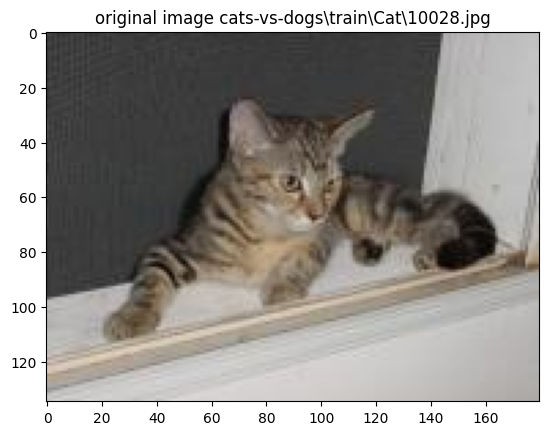

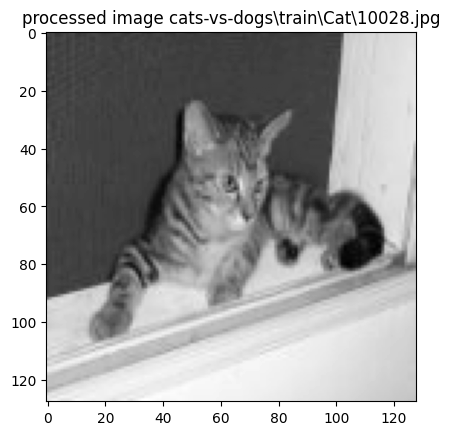

In [15]:
# Affichage de l'image originale
rgb_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB) # Changement d'ordre des canaux de couleur
# Affichage avec matplotlib
plt.imshow(rgb_img)
plt.title("original image " + img_path)
plt.show()

# Affichage de l'image convertie
plt.imshow(processed_img, cmap="gray") # L'argument cmap="gray" permet d'afficher l'image en niveaux de gris
plt.title("processed image " + img_path)
plt.show()

#### Pré-traitement des dossiers d'entraînement et de test

Le classifieur attend en entrée une matrice X. Pour l'entraînement, il a de plus besoin d'une matrice y. 

La **matrice X** contient toutes les images aplaties : chaque ligne représente une image. Chaque image étant de taille 128x128, elles ont une taille de 16 384 une fois aplaties dans un vecteur unidimensionel. La matrice X a donc pour dimension nombre d'images * 16 384. 

La **matrice y** contient les caractéristiques de chaque image. Nous allons représenter chaque caractéristique par un vecteur de taille 2 : (1, 0) pour les chats, et (0, 1) pour les chiens. Cette représentation, nommée "un parmi n", est fréquemment utilisée en apprentissage automatique. 

Pour créer ces matrices, nous définissons une fonction, ```grayscale_resize_normalize_folder```, qui prend le chemin vers un dossier en entrée et qui renvoie en sortie une matrice X d'images et une matrice y d'étiquettes.

In [16]:
def grayscale_resize_normalize_folder(input_folder_path, output_image_size):
    # On initialise la liste X_list, qui contiendra chaque image sous forme d'un vecteur unidimensionnel,
    # et la liste y, qui contiendra chaque étiquette sous forme d'un entier égal à 0 ou 1
    X_list = []
    y_list = []
    # On considère chacun des animaux successivement
    for class_id, pet_dir in enumerate([cat_dir, dog_dir]):
        print("Traitement des images du dossier", pet_dir)
        print("Ces images ont l'étiquette", [class_id, 1-class_id])
        # On boucle sur toutes les images de ce dossier
        for image_filename in os.listdir(os.path.join(input_folder_path, pet_dir)):
            # On prétraite l'image
            img_path = os.path.join(input_folder_path, pet_dir, image_filename)
            preprocessed_img = grayscale_resize_normalize_image(img_path, output_image_size)
            if preprocessed_img is not None:
                # On applatit l'image pour qu'elle forme un vecteur
                X = np.reshape(preprocessed_img, output_image_size*output_image_size)
                # On l'ajoute à la liste
                X_list.append(X)
                y_list.append(class_id)

    # On mélange les deux listes de la même manière
    xy = list(zip(X_list, y_list))
    random.shuffle(xy)
    X_tuple, y_tuple = zip(*xy)

    # On convertit X_tuple depuis un tuple de vecteurs en une matrice numpy
    X = np.stack(X_tuple, axis=0)
    
    # On encode y_tuple avec un encodage "un parmi n". 
    y = np.asarray(y_tuple)
    y = np.stack([y, 1-y], axis=-1)
    
    return X, y

On peut maintenant appliquer cette fonction aux dossiers ```train``` et ```test```, pour constituer les matrices X_train (contenant toutes les images d'entraînement) et X_test (contenant toutes les images de test), ainsi que y_train (contenant toutes les étiquettes d'entraînement) et y_test (contenant toutes les étiquettes de test). 

In [17]:
X_train, y_train = grayscale_resize_normalize_folder(os.path.join(root_dir, train_dir), img_size)
X_test, y_test = grayscale_resize_normalize_folder(os.path.join(root_dir, test_dir), img_size)

Traitement des images du dossier Cat
Ces images ont l'étiquette [0, 1]
Traitement des images du dossier Dog
Ces images ont l'étiquette [1, 0]
could not read image  cats-vs-dogs\train\Dog\7969.jpg
Traitement des images du dossier Cat
Ces images ont l'étiquette [0, 1]
Traitement des images du dossier Dog
Ces images ont l'étiquette [1, 0]


On va maintenant vérifier la dimension de ces matrices en affichant leur attribut ```shape```. 

In [18]:
print("X_train.shape", X_train.shape)
print("y_train.shape", y_train.shape)
print("X_test.shape", X_test.shape)
print("y_test.shape", y_test.shape)

X_train.shape (399, 16384)
y_train.shape (399, 2)
X_test.shape (100, 16384)
y_test.shape (100, 2)


Les matrices X ont, comme prévu, 16 384 colonnes. En effet, chaque ligne représente une image de taille 128x128 aplatie dans un vecteur unidimensionnel. 

X_train a 400 lignes, cet ensemble de données contient donc 400 images. Par conséquent, y_train a 400 lignes. De plus, comme nous voulons classifier les images en deux catégories, y_train a 2 colonnes. 

X_test a 100 colonnes, ce qui correspond aux 100 images utilisées pour les tests. y_test a 100 lignes, et 2 colonnes. 

## Création d'un classifieur linéaire <a class="anchor" id="classifieur"></a>

Un classifieur linéaire prend une image en entrée, et calcule un score pour chaque classe. Ce score représente la probabilité que l'image appartienne à cette classe, et est calculé comme une fonction linéaire des intensités de l'image. 

Plus formellement, on peut représenter ce classifieur comme une matrice de pondération $W$, telle que : $y = W X$. Dans cette équation, $y$ est la matrice contenant les scores de chaque classe de chaque image, et $X$ est la matrice contenant toutes les images aplaties.

Notons que les dimensions de la matrice de pondération $W$ sont entièrement déterminées par celles de $X$ et $y$ : ici, c'est une matrice de taille 2 par 16 384.

Le rôle de l'apprentissage est d'identifier les poids de $W$ qui permettent d'obtenir la meilleure classification possible. Pour cela, nous allons suivre les étapes suivantes :
- Initialisation des poids de $W$ de manière aléatoire ;
- Définition d'une fonction coût qui mesure la performance de la classification ;
- Utilisation d'une descente de gradient pour identifier les poids qui minimisent cette fonction coût.

### Création et initialisation de la matrice de pondération <a class="anchor" id="matrice_ponderation"></a>

Nous allons créer notre classifieur linéaire dans une classe, à laquelle nous ajouterons des méthodes membres au fur et à mesure de notre avancement. 

Commençons par le constructeur.

Le constructeur prend deux arguments : la taille des images acceptées en entrée par le classifieur (nous définissons une taille par défaut correspondant à la taille définie plus haut), et le nombre de classes (nous choisissons 2 classes par défaut). Ces deux valeurs définissent la taille de matrice de pondération. 

Le constructeur se contente d'initialiser les attributs de la classe, ainsi que la matrice de pondération. Pour cela, on utilisera l'[initialisation de Xavier](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf?hc_location=ufi]). Avec l'initialisation de 
[He](http://openaccess.thecvf.com/content_iccv_2015/html/He_Delving_Deep_into_ICCV_2015_paper.html), c'est la méthode dont l'utilisation est la plus répandue en apprentissage automatique. 

La formule de l'initialisation de Xavier est la suivante :

\begin{equation}
W_{ij} \sim U\left[ -\frac{1}{\sqrt{n}}, \frac{1}{\sqrt{n}} \right],
\end{equation}
avec $U$ la densité de probabilité de la loi uniforme, et $n$ le nombre de colonnes dans la matrice de pondération (16384 ici).

In [19]:
class LinearClassifier(object):
    def __init__(self, image_size=16384, nb_classes=2):
        self.image_size = image_size
        self.nb_classes = nb_classes
        
        # Initialition des poids
        self._initialize_weights()
        
    def _initialize_weights(self):
        # Initialisation des poids selon la méthode Xavier
        np.random.seed(0)
        self.W = np.random.uniform(low = -1/np.sqrt(self.image_size), 
                                   high=1/np.sqrt(self.image_size),
                                   size=(self.nb_classes, self.image_size)) 

Nous définissons maintenant une fonction pour estimer les probabilités d'appartenance à une classe. 

Cette fonction, nommée ```predict```, va simplement multiplier l'image par la matrice de pondération, et appliquer la fonction softmax au résultat. 

Cette fonction s'exprime comme :

\begin{equation}
softmax(y_i) = \frac{e^{y_i}}{\sum_j e^{y_j}}, y_j = \{Wx\}_j
\end{equation}

et permet de convertir le score de chaque classe en probabilité. 

En sortie, elle renvoie un vecteur de taille 2, dont chaque élément est la probabilité que l'image appartienne à une des classes.

In [20]:
def predict(self, X, epsilon=1e-5):
    y = np.matmul(X, self.W.T)

    # Application de la fonction softmax - le paramètre epsilon permet d'éviter les divisions par 0
    y = np.exp(y)/np.sum(np.exp(y) + epsilon, axis=-1, keepdims=True)
    
    # On renvoie la matrice de prédiction
    return y

# Cette ligne permet d'assigner la méthode predict à la classe LinearClassifier
setattr(LinearClassifier, 'predict', predict)

On peut d'ores et déjà utiliser notre classifieur (avec des poids aléatoires) pour prédire la classe d'images tirées au hasard. 

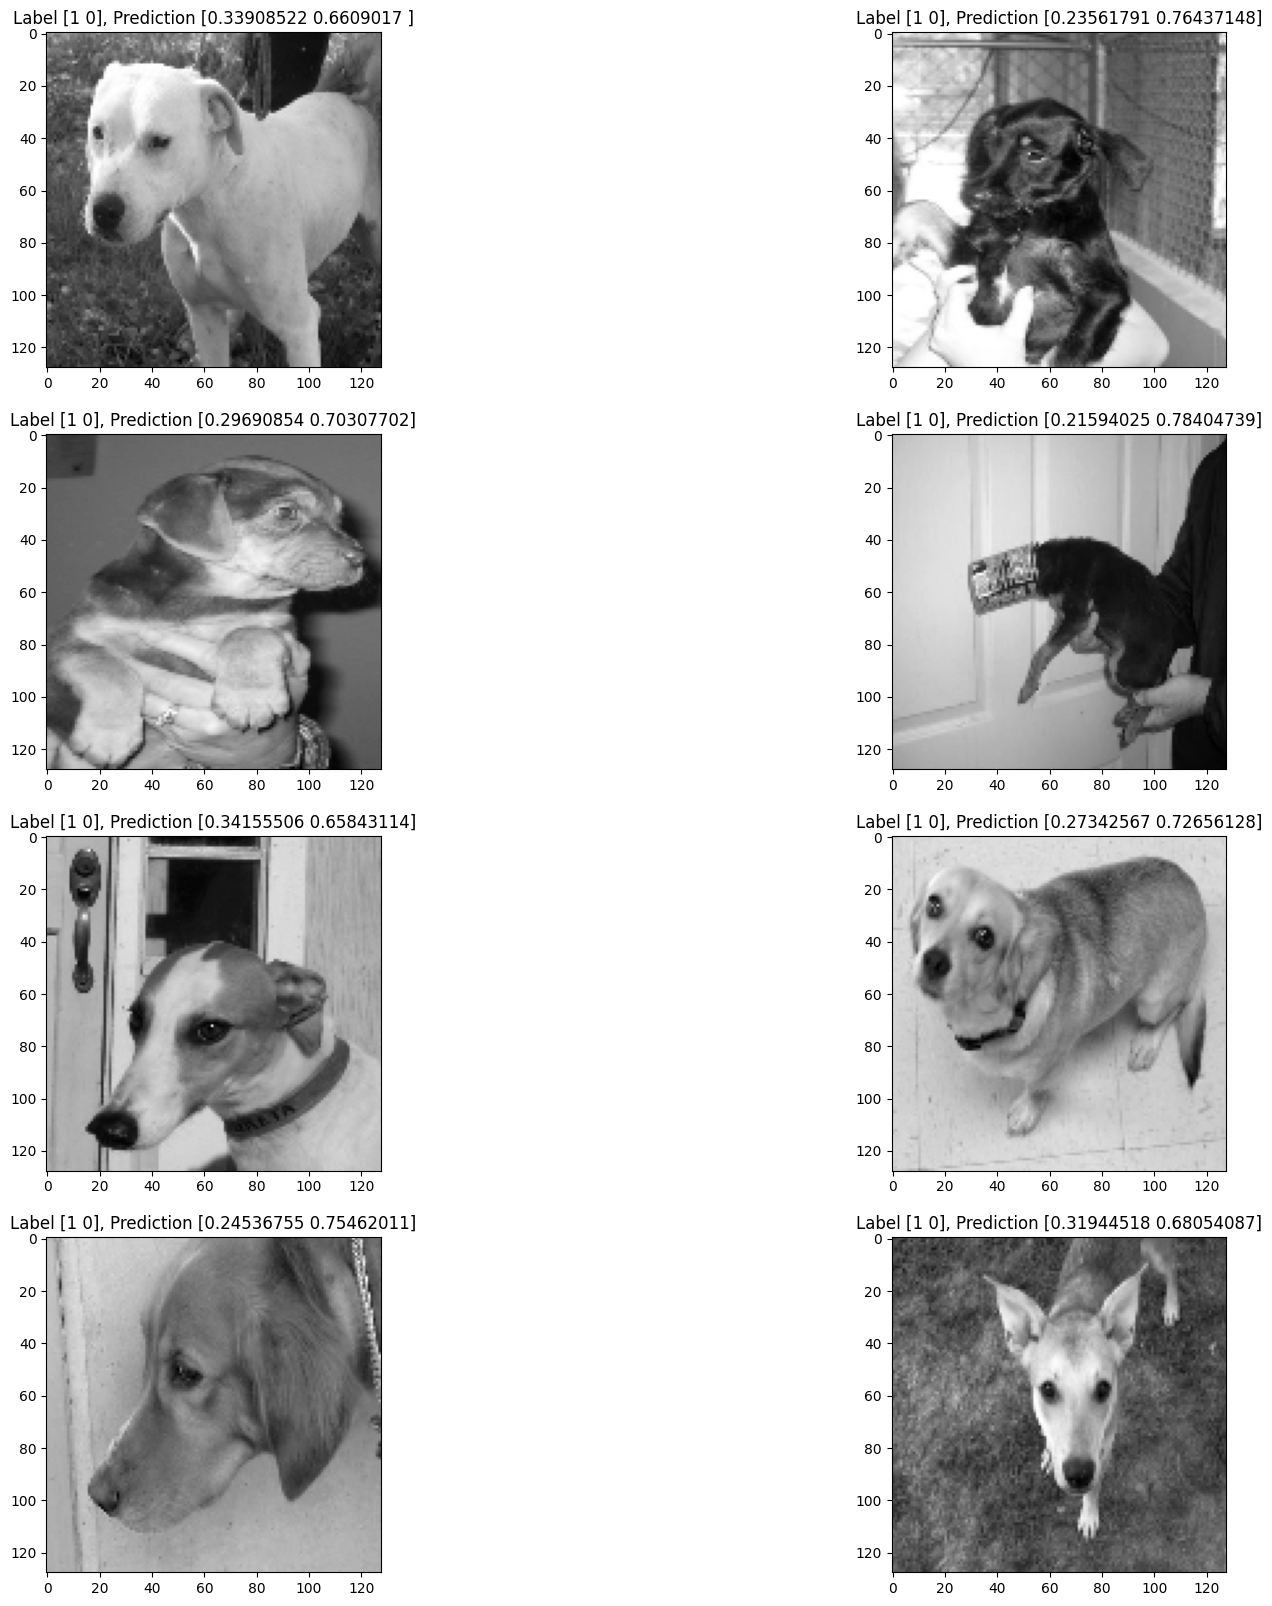

In [21]:
classifier = LinearClassifier()

# Création d'un graphique contenant huit sous-figures, organisées en 4 lignes et 2 colonnes
fig, axes = plt.subplots(4, 2, figsize=(20,20))
# Boucle sur les 8 premières images de notre matrices X_train
for i in range(8):
    # On récupère l'image i
    image_vecteur = X_train[i,:]
    
    # On remet le vecteur image_vecteur sous la forme d'une image de taille 128x128 pour l'affichage
    image = np.reshape(image_vecteur, (img_size,img_size))
    
    # On prédit sa classe en utilisant la fonction predict
    y_pred = classifier.predict(image_vecteur)
    
    # On affiche les résultats
    axes.flatten()[i].imshow(image, cmap='gray')
    axes.flatten()[i].set_title('Label ' + str(y_train[i]) +', Prediction ' + str(y_pred))

Le classifieur non optimisé n'est pas très performant. Voyons s'il sera meilleur après optimisation de ses poids. 

### Définition d'une fonction coût  <a class="anchor" id="fonction_cout"></a>

La fonction coût généralement associée au classifieur softmax est l'**entropie croisée**. Cette fonction nous permet de quantifier l'écart entre la vraie classe de l'image et la classe prédite, et sa formule est la suivante :

\begin{equation}
L = \frac{-1}{n}\sum_{i=1}^n \sum_{j=0}^1 \textrm{y_true}_{ij} \log(\textrm{y_pred}_{ij}),
\end{equation}

où :
- $n$ est le nombre d'images considérées ;
- $\textrm{y_true}$ représente la vraie classe de l'image, $\textrm{y_true}_{ij}$ étant la probabilité que l'image $i$ appartienne à la classe $j$ ;
- $\textrm{y_pred}$ est la prédiction de l'image, $\textrm{y_pred}_{ij}$ étant la probabilité prédite que l'image $i$ appartienne à la classe $j$.

Comme pour la fonction de prédiction, nous assignons cette fonction à la classe ```LinearClassifier``` après sa définition.

In [22]:
def loss(self, X, y_true):
    y_pred = self.predict(X)
    loss = np.mean(-y_true * np.log(y_pred))
    return loss

# Cette ligne permet d'assigner la méthode loss à la classe LinearClassifier
setattr(LinearClassifier, 'loss', loss)

### Définition de la descente de gradient  <a class="anchor" id="descente_gradient"></a>

La descente de gradient consiste à estimer de manière itérative la matrice de pondération $W$ afin de minimiser la fonction coût $L$. A chaque itération $k$, la nouvelle matrice est donnée par :
\begin{equation}
W_{k+1} = W_k - \rho \Delta_W L(W_k),
\end{equation}

avec $\rho$ le taux d'apprentissage (qui fait partie des hyperparamètres à sélectionner) et $\Delta_W L(W_k)$ le gradient selon $W$ de la fonction de perte $L$, appliqué à $W_k$. 


Le gradient selon $W$ de la fonction de perte $L$ est facilement calculable. Il est donné par :

\begin{equation}
\Delta_W L = X (\textrm{y_pred}-\textrm{y_true}).
\end{equation}

In [23]:
def grad(self, X, y):
    # Calculer le vecteur de prédictions
    p = self.predict(X)
    # Calculer le gradient    
    gradient = np.matmul((p-y).T, X)    
    return gradient
    
# Cette ligne permet d'assigner la méthode grad à la classe LinearClassifier
setattr(LinearClassifier, 'grad', grad)

Il ne nous reste plus qu'à écrire une fonction réalisant la descente de gradient, ```fit```. 

Dans la version stochastique de la descente de gradient, le gradient est calculé à chaque itération avec un sous-ensemble des images uniquement. 

Le nombre de sous-images est un hyperparamètre à choisir. Il est communément appelé *taille de lot*. 

Le nombre d'itérations pour parvenir à convergence dépendant de cette taille de lot. En effet, on ne définit généralement pas le nombre d'itérations, mais le nombre d'*époques*,  une époque étant l'ensemble d'itération nécessaires pour que la descente de gradient voie toutes les images. 

Les arguments de la fonction ```fit```, outre les images et les étiquettes d'entraînement, comprend donc tous ces hyperparamètres : 
- Le nombre d'époques (```n_epochs```) avant interruption de l'optimisation ;
- La taille de lot (```batch_size```) ;
- Le taux d'apprentissage (```learning_rate```).

En sortie, cette fonction renvoie la liste des valeurs de la fonction de perte. Si l'optimisation se déroule bien, nous devrions voir une diminution de la fonction de perte au fur et à mesure des itérations. 

In [24]:
def fit(self, X_train, y_train, n_epochs, batch_size=32, learning_rate=1e-5):
    # On boucle sur les époques
    loss_list = []
    for epoch in range(n_epochs):
        # le nombre d'époques, le nombre d'images et la taille de batch définissent le nombre de batches contenu dans une époque
        n_batches = int(np.floor(X_train.shape[0] / batch_size))
        
        # Afin d'avoir une séparation de notre ensemble de données d'entraînement différente à chaque époque, 
        # on mélange aléatoirement les indices de la matrice X_train
        index = np.arange(X_train.shape[0])
        np.random.shuffle(index)
        
        # On boucle maintenant sur les batches
        for batch in range(n_batches):
            beg = batch*batch_size
            end = (batch+1)*batch_size if (batch+1)*batch_size < X_train.shape[1] else -1
            X_batch = X_train[index[beg:end],:]
            y_batch = y_train[index[beg:end]]
            
            # Calcul de la fonction de perte            
            loss = self.loss(X_batch, y_batch)
            loss_list.append(loss)
            
            # Calcul du gradient
            gradient = self.grad(X_batch, y_batch)
            
            # Mise à jour des poids            
            self.W -= learning_rate * gradient
        
    # On renvoie la liste des valeurs de la fonction de perte
    return loss_list

# Cette ligne permet d'assigner la méthode fit à la classe LinearClassifier
setattr(LinearClassifier, 'fit', fit)

## Entraînement du classifieur <a class="anchor" id="entrainement"></a>

On peut maintenant entraîner notre classifieur, et tracer le graphique représentant les valeurs de la fonction de perte au cours des itérations. 

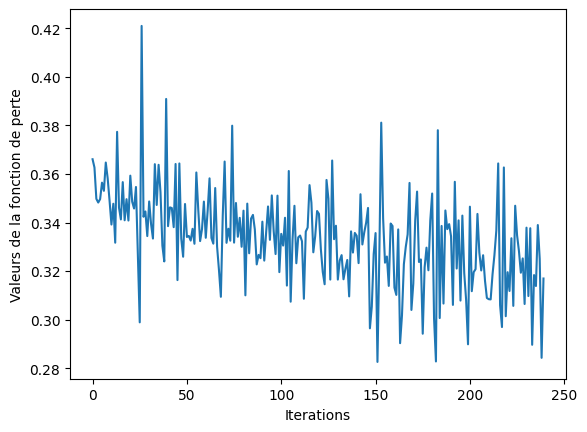

Valeur de la fonction de perte à la première itération :  0.3660612421736011
Valeur de la fonction de perte à la dernière itération :  0.31695327214082053


In [25]:
classifier = LinearClassifier()
loss = classifier.fit(X_train, y_train, n_epochs=20)

# Affichage des valeurs de la fonction de perte
plt.plot(loss)
plt.ylabel('Valeurs de la fonction de perte')
plt.xlabel('Iterations')
plt.show()

print("Valeur de la fonction de perte à la première itération : ", loss[0])
print("Valeur de la fonction de perte à la dernière itération : ", loss[-1])

## Evaluation du classifieur <a class="anchor" id="evaluation"></a>

L'étape d'évaluation est une étape critique du développement d'un modèle d'intelligence artificielle. 

Pour les problèmes de classification binaire, on utilise typiquement trois mesures :
- La **précision** est définie comme le nombre d'images correctement attribuées à la classe i par rapport au nombre total d'images prédites comme appartenant à la classe i. Elle se calcule comme :
\begin{equation}
\textrm{prec} = \frac{\textrm{Nombre de vrais positifs}}{\textrm{Nombre de vrais positifs + Nombre de faux positifs}}
\end{equation}
- La **sensibilité** est définie le nombre d'images correctement attribuées à la classe i par rapport au nombre total d'images appartenant effectivement à la classe i. Elle se calcule comme :
\begin{equation}
\textrm{sens} = \frac{\textrm{Nombre de vrais positifs}}{\textrm{Nombre de vrais positifs + Nombre de faux négatifs}}
\end{equation}
- Le **score F1** est la moyenne harmonique entre précision et sensibilité. Il se calcule comme : 
\begin{equation}
\textrm{F1} = \frac{\textrm{prec}* \textrm{sens}}{\textrm{prec}+\textrm{sens}}
\end{equation}


Nous calculerons également une matrice de confusion pour visualiser les résultats. 

Tous ces calculs utiliseront la base de données de test.

Nous commençons par visualiser plusieurs prédictions faites sur la base de test. 

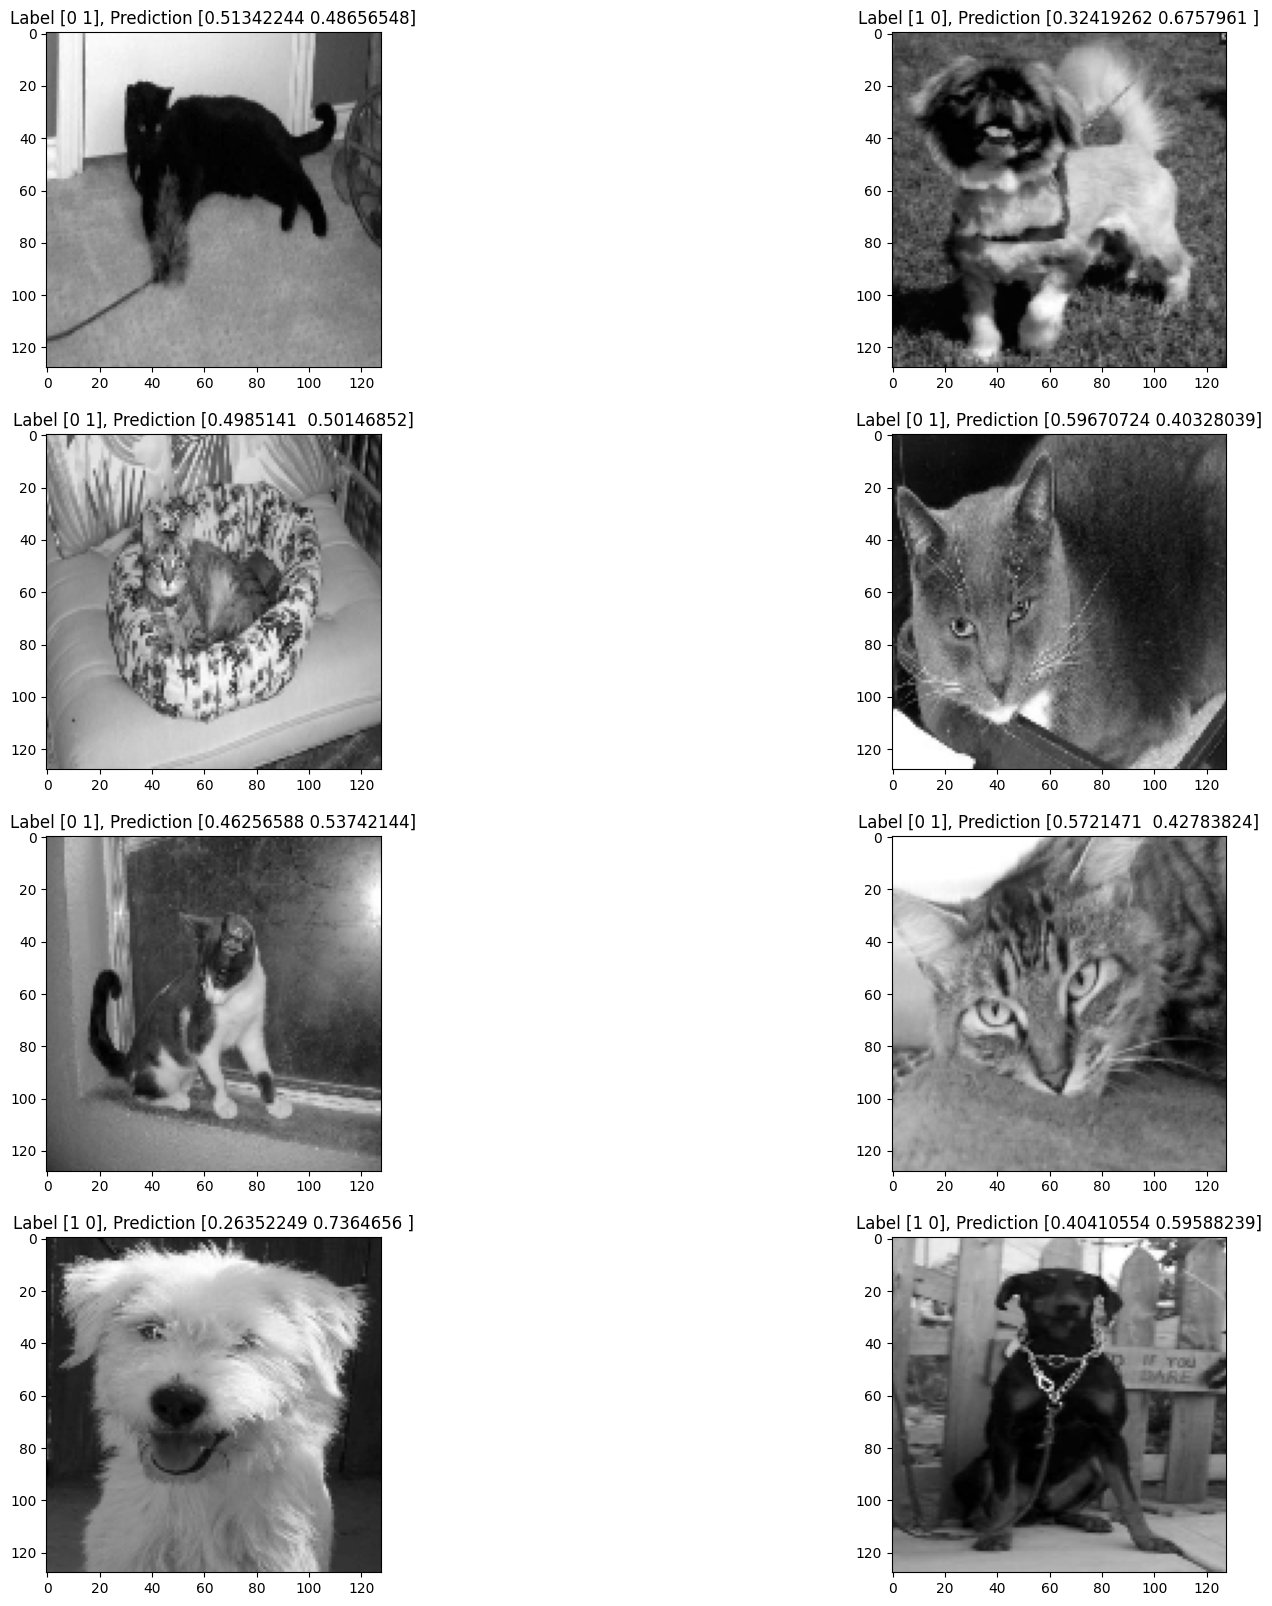

In [26]:
# Création d'un graphique contenant huit sous-figures, organisées en 4 lignes et 2 colonnes, 
# chacune mesurant 20 inches de côté
fig, axes = plt.subplots(4, 2, figsize=(20,20))
# Boucle sur les 8 premières images de notre matrices X_train
for i in range(8):
    # On récupère l'image i
    image_vecteur = X_test[i,:]
    
    # On remet le vecteur image_vecteur sous la forme d'une image de taille 128x128 pour l'affichage
    image = np.reshape(image_vecteur, (img_size,img_size))
    
    # On prédit sa classe en utilisant la fonction predict
    y_pred = classifier.predict(image_vecteur)
    
    # On affiche les résultats
    axes.flatten()[i].imshow(image, cmap='gray')
    axes.flatten()[i].set_title('Label ' + str(y_test[i]) +', Prediction ' + str(y_pred))

Nous pouvons maintenant calculer les valeurs de prévision, spécificité et score F1 pour toutes ces images, en utilisant le sous-paquet ```metrics``` de la bibliothèque ```sklearn```. 

Ce paquet nécessite que les étiquettes soient encodées au format binaire (0 pour les chiens et 1 pour les chats). Nous devons donc convertir les étiquettes prédites et réelles depuis le format "un parmi n" vers ce format. Pour cela, nous utilisons la fonction ```argmax```de ```numpy```, qui appliquée à un vecteur, renvoie l'indice qui contient la valeur maximale. 

Par exemple, considérons un vecteur de prédiction $y = [0.67, 0.33]$, qui correspond à un chien avec l'encodage "un parmi n".
L'indice contenant la valeur maximale est l'indice 0, ce qui correspond bien à la classe du chien avec l'encodage au format binaire.

In [27]:
# Calcul des prédictions pour les images contenues dans X_train
y_pred = classifier.predict(X_test)

# Conversion des prédictions et des étiquette réelles au format binaire 
y_pred_bin = np.argmax(y_pred, axis=-1)
y_test_bin = np.argmax(y_test, axis=-1)

# Calcul des métriques en utilisant les fonctions de metrics
precision = sklearn.metrics.precision_score(y_test_bin, y_pred_bin)
recall = sklearn.metrics.recall_score(y_test_bin, y_pred_bin)
f1 = sklearn.metrics.f1_score(y_test_bin, y_pred_bin)
acc = sklearn.metrics.accuracy_score(y_test_bin, y_pred_bin)

print('Précision sur les données de test :', precision)
print('Sensibilité sur les données de test:', recall)
print('Score F1 sur les données de test', f1)
print('Accuracy sur les données de test', acc)

Précision sur les données de test : 0.5161290322580645
Sensibilité sur les données de test: 0.64
Score F1 sur les données de test 0.5714285714285714
Accuracy sur les données de test 0.52


La bibliothèque ```sklearn``` a aussi une fonction qui permet de tracer la matrice de confusion. 

Il s'agit de la fonction ```ConfusionMatrixDisplay.from_predictions```, qui prend en entrée deux arguments obligatoires :
- une liste d'étiquettes réelles au format binaire ;
- une liste d'étiquettes prédites au format binaire. 

Cette fonction accepte également plusieurs arguments facultatifs. Ici, on précise une colormap bleue, qui est différente de celle choisie par défaut, mais conforme à la manière dont sont généralement affichées les matrices de confusion. 

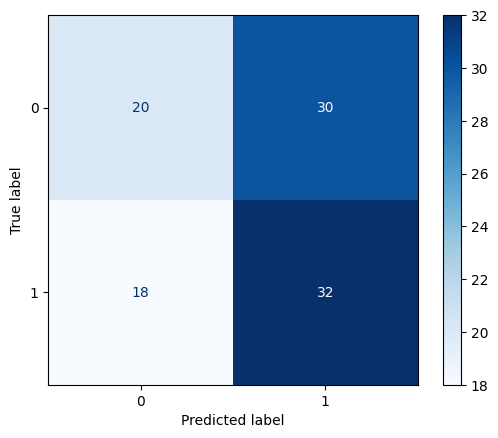

In [28]:
sklearn.metrics.ConfusionMatrixDisplay.from_predictions(y_test_bin, y_pred_bin, cmap='Blues')

## Conclusion <a class="anchor" id="conclusion"></a>

Cet exercice nous a permis d'aborder plusieurs sujets :
- La création d'ensembles de données d'entraînement et de test, leur organisation, les prétraitements à appliquer aux images ;
- Le fonctionnement d'un classifieur linéaire ;
- Le calcul et l'affichage de métriques classiques en classification binaire. 

Les performances obtenues sont plutôt faibles. 

D'une part, parce que l'utilisation d'un classifieur linéaire n'est pas très bien adaptée à la classification d'images dites "naturelles" (c'est à dire des photos prises sans contraintes particulières) : comme nous l'avons vu plus haut dans ce chapitre, appliquer un classifieur linéaire revient à appliquer un filtre linéaire sur l'image, toujours le même, et toujours à la même position. Il est clair qu'un tel outil ne nous permettra pas de distinguer les chiens des chats, alors que chaque image présente un animal placé à un endroit différent de l'image, et avec un fond différent. 

D'autre part, ce classifieur linéaire peut encore être optimisé. 

## A vous de jouer ! <a class="anchor" id="avousdejouer"></a>

Pouvez-vous augmenter la précision du classifieur ?
Voici quelques pistes :
- Effectuez plus d'itérations ;
- Modifiez le pas d'apprentissage de la fonction d'optimisation ;
- Modifiez la taille de lot ;
- Modifiez la taille des images, ou la manière dont elles sont redimensionnées ;
- Etc.